In [2]:
import pandas as pd
import pickle
import numpy as np

products_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/raw/products.pkl'

# Products

## Cargar dataset

In [3]:
# Cargar el archivo .pkl
with open(products_data_path, 'rb') as file:
    products_df = pickle.load(file)

# Si el archivo es un DataFrame, exploramos su contenido
if isinstance(products_df, pd.DataFrame):
    # Información básica
    print(products_df.info())
    # Mostrar las primeras filas
    print(products_df.head())
else:
    print("El archivo no contiene un DataFrame. Contenido:", type(products_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   discount     43692 non-null  object 
 1   embedding    37522 non-null  object 
 2   partnumber   43692 non-null  int32  
 3   color_id     43692 non-null  int32  
 4   cod_section  43602 non-null  float64
 5   family       43692 non-null  int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 1.5+ MB
None
  discount                                          embedding  partnumber  \
0        0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1        0  [-0.0949274, -0.107294075, -0.16559914, -0.174...       41431   
2        0  [-0.12904441, -0.07724628, -0.09799071, -0.164...       39419   
3        1  [-0.12783332, -0.133868, -0.10101265, -0.18888...       36087   
4        1  [-0.14092924, -0.1258284, -0.10809927, -0.1765...       34132   

   color_id  cod_section  

## Análisis inicial

### Explorar valores únicos y manejar los valores nulos

In [16]:
# Valores únicos por columna (excluyendo 'embedding')
for column in products_df.columns:
    if column != 'embedding':
        print(f"Columna '{column}': {products_df[column].nunique()} valores únicos")
    else:
        print(f"Columna '{column}': contiene listas/arrays, no se puede calcular valores únicos directamente.")

# Resumen de valores nulos
print("\nValores nulos por columna:")
print(products_df.isnull().sum())

# Estadísticas básicas para columnas numéricas (excluyendo embedding)
print("\nEstadísticas descriptivas:")
print(products_df.drop(columns='embedding', errors='ignore').describe())

# Revisión de las primeras filas para valores nulos
print("\nMuestras con valores nulos en 'cod_section':")
print(products_df[products_df['cod_section'].isnull()].head())

print("\nMuestras con valores nulos en 'embedding':")
print(products_df[products_df['embedding'].isnull()].head())


Columna 'discount': 2 valores únicos
Columna 'embedding': contiene listas/arrays, no se puede calcular valores únicos directamente.
Columna 'partnumber': 43692 valores únicos
Columna 'color_id': 638 valores únicos
Columna 'cod_section': 4 valores únicos
Columna 'family': 217 valores únicos

Valores nulos por columna:
discount          0
embedding      6170
partnumber        0
color_id          0
cod_section      90
family            0
dtype: int64

Estadísticas descriptivas:
         partnumber      color_id   cod_section        family
count  43692.000000  43692.000000  43602.000000  43692.000000
mean   21846.500000    176.133320      2.209922     95.949922
std    12612.938317    147.611806      1.190734     57.816870
min        1.000000      1.000000      1.000000      1.000000
25%    10923.750000     64.000000      1.000000     51.000000
50%    21846.500000    135.000000      2.000000     74.000000
75%    32769.250000    307.000000      3.000000    153.000000
max    43692.000000    6

### Tratamiento de valores nulos embedding y cod_section

- `Columna embedding:` Imputada con el vector promedio calculado.
- `Columna cod_section:` Imputada con su moda (valor más frecuente).

In [17]:
import numpy as np

# Extraer solo los embeddings no nulos
valid_embeddings = products_df['embedding'].dropna()

# Verificar la longitud de los embeddings
embedding_lengths = valid_embeddings.apply(len)

# Comprobar si todos los embeddings tienen la misma longitud
print(f"Longitud mínima: {embedding_lengths.min()}, Longitud máxima: {embedding_lengths.max()}")

# Si todos los embeddings tienen la misma longitud, calcular el promedio
if embedding_lengths.min() == embedding_lengths.max():
    embedding_mean = np.mean(np.vstack(valid_embeddings), axis=0)
    print("Se puede calcular un promedio para imputar.")
else:
    print("Los embeddings tienen longitudes variables; no se puede calcular un promedio.")


Longitud mínima: 1280, Longitud máxima: 1280
Se puede calcular un promedio para imputar.


In [18]:
import numpy as np

# Calcular el promedio de los vectores de embedding no nulos
embedding_mean = np.mean(np.vstack(products_df['embedding'].dropna()), axis=0)

# Imputar los valores nulos con el vector promedio
products_df['embedding'] = products_df['embedding'].apply(
    lambda x: embedding_mean if x is None or isinstance(x, float) and np.isnan(x) else x
)

# Verificar que no queden valores nulos
print(f"Valores nulos en 'embedding' después de imputación: {products_df['embedding'].isna().sum()}")


Valores nulos en 'embedding' después de imputación: 0


In [19]:
# Calcular la moda de 'cod_section'
cod_section_mode = products_df['cod_section'].mode()[0]
print(f"Moda de 'cod_section': {cod_section_mode}")

# Imputar valores nulos con la moda
products_df['cod_section'] = products_df['cod_section'].fillna(cod_section_mode)

# Verificar que no queden valores nulos
print(f"Valores nulos en 'cod_section' después de imputación: {products_df['cod_section'].isna().sum()}")


Moda de 'cod_section': 1.0
Valores nulos en 'cod_section' después de imputación: 0


### Optimización dataset

In [20]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   discount     43692 non-null  object 
 1   embedding    43692 non-null  object 
 2   partnumber   43692 non-null  int32  
 3   color_id     43692 non-null  int32  
 4   cod_section  43692 non-null  float64
 5   family       43692 non-null  int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 1.5+ MB


In [21]:
products_df.describe()

,partnumber,color_id,cod_section,family
count,43692.000000,43692.000000,43692.000000,43692.000000
mean,21846.500000,176.133320,2.207429,95.949922
std,12612.938317,147.611806,1.190771,57.816870
min,1.000000,1.000000,1.000000,1.000000
25%,10923.750000,64.000000,1.000000,51.000000
50%,21846.500000,135.000000,2.000000,74.000000
75%,32769.250000,307.000000,3.000000,153.000000
max,43692.000000,638.000000,4.000000,217.000000


In [22]:
# Convertir columnas al tipo de dato más eficiente
products_df['discount'] = products_df['discount'].astype('int8')
products_df['cod_section'] = products_df['cod_section'].astype('int8')
# partnumber, color_id y family ya están optimizados como int32, no es necesario cambiarlos

# Verificar el uso de memoria después de la optimización
print("Uso de memoria después de la optimización:")
print(products_df.info())


Uso de memoria después de la optimización:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   discount     43692 non-null  int8  
 1   embedding    43692 non-null  object
 2   partnumber   43692 non-null  int32 
 3   color_id     43692 non-null  int32 
 4   cod_section  43692 non-null  int8  
 5   family       43692 non-null  int32 
dtypes: int32(3), int8(2), object(1)
memory usage: 938.8+ KB
None


## Análisis descriptivo

- Estadísticas descriptivas generales.
- Distribución de las variables categóricas y numéricas.
- Detección de valores únicos y proporciones.


Valores únicos por columna:
Columna 'discount': 2 valores únicos
Columna 'embedding': Contiene listas/vectores, no se puede calcular directamente.
Columna 'partnumber': 43692 valores únicos
Columna 'color_id': 638 valores únicos
Columna 'cod_section': 4 valores únicos
Columna 'family': 217 valores únicos


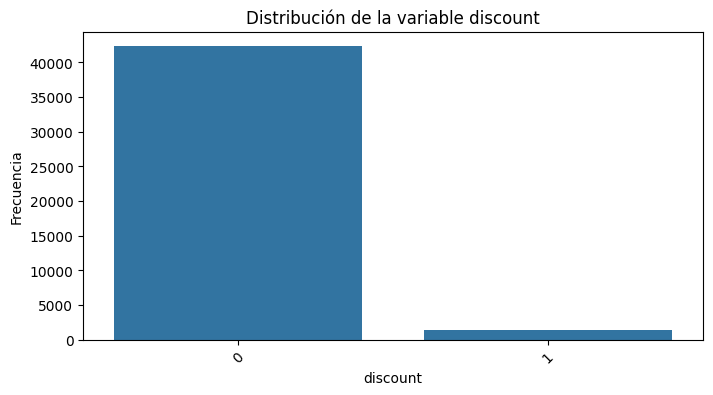

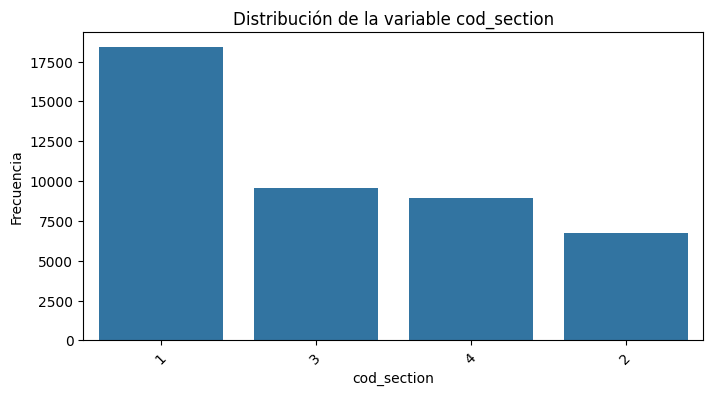

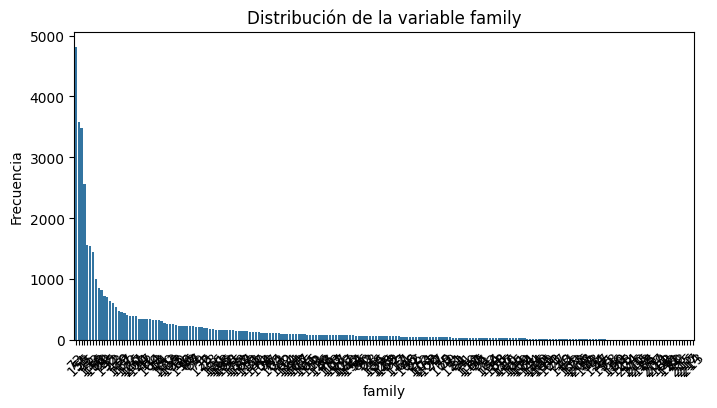

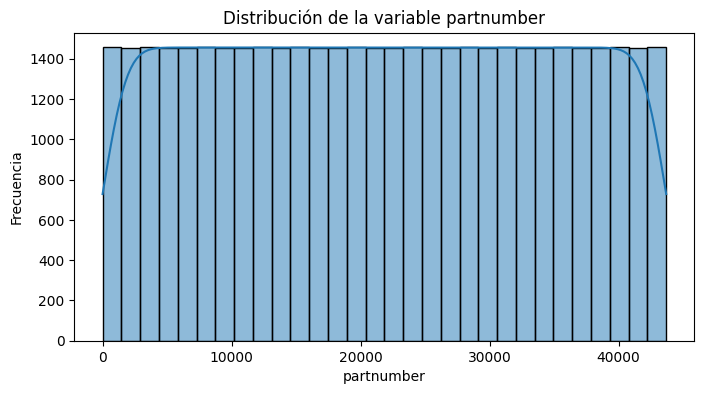

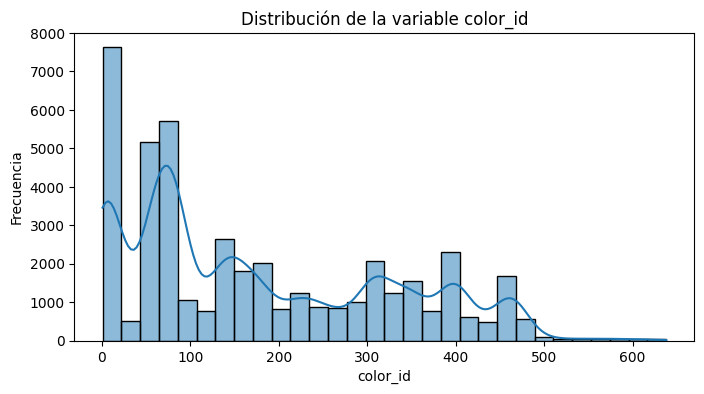


Proporción de valores únicos en 'discount':
discount
0    96.846105
1     3.153895
Name: proportion, dtype: float64

Proporción de valores únicos en 'cod_section':
cod_section
1    42.147304
3    21.834661
4    20.527785
2    15.490250
Name: proportion, dtype: float64

Proporción de valores únicos en 'family':
family
73     11.024902
156     8.175410
51      7.962556
53      5.856907
15      3.565870
         ...    
215     0.002289
216     0.002289
217     0.002289
214     0.002289
213     0.002289
Name: proportion, Length: 217, dtype: float64

Proporción de valores únicos en 'partnumber':
partnumber
32776    0.000023
25473    0.000023
28822    0.000023
25251    0.000023
25252    0.000023
Name: proportion, dtype: float64

Proporción de valores únicos en 'color_id':
color_id
3      0.131031
64     0.074865
83     0.062048
397    0.033484
85     0.031379
Name: proportion, dtype: float64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estadísticas descriptivas generales
# print("Estadísticas descriptivas generales:")
# print(products_df.describe(include='all'))

# Conteo de valores únicos por columna
print("\nValores únicos por columna:")
for column in products_df.columns:
    if column == 'embedding':
        print(f"Columna '{column}': Contiene listas/vectores, no se puede calcular directamente.")
    else:
        print(f"Columna '{column}': {products_df[column].nunique()} valores únicos")

# Distribución de variables categóricas
categorical_cols = ['discount', 'cod_section', 'family']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=products_df, x=col, order=products_df[col].value_counts().index)
    plt.title(f"Distribución de la variable {col}")
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

# Distribución de variables numéricas
numerical_cols = ['partnumber', 'color_id']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=products_df, x=col, bins=30, kde=True)
    plt.title(f"Distribución de la variable {col}")
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Detección de valores únicos en variables categóricas
for col in categorical_cols:
    unique_vals = products_df[col].value_counts(normalize=True) * 100
    print(f"\nProporción de valores únicos en '{col}':")
    print(unique_vals)

# Detección de valores únicos en variables numéricas
for col in numerical_cols:
    print(f"\nProporción de valores únicos en '{col}':")
    print(products_df[col].value_counts(normalize=True).head())


In [24]:
# Describir solo columnas numéricas estándar
standard_stats = products_df.drop(columns=['embedding']).describe()

# Cálculo separado para embeddings si es necesario
embeddings_stats = {
    "mean": np.mean(np.vstack(products_df['embedding']), axis=0),
    "std": np.std(np.vstack(products_df['embedding']), axis=0)
}

standard_stats.describe()

,discount,partnumber,color_id,cod_section,family
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,5461.650789,23422.992290,5645.093141,5463.299775,5542.720849
std,15447.393818,15746.503393,15374.518244,15446.727558,15414.779336
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,12190.641238,117.250000,1.143079,56.112652
50%,0.015769,21846.500000,161.872563,2.103715,84.974961
75%,0.381078,35499.937500,389.750000,3.250000,169.000000
max,43692.000000,43692.000000,43692.000000,43692.000000,43692.000000


## Redimensionado de los embeddings

In [4]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Extraer embeddings y convertirlos a matriz densa
embeddings_matrix = np.vstack(products_df['embedding'])

# Aplicar PCA para reducir la dimensionalidad a 50 componentes
pca = PCA(n_components=50, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings_matrix)

# Verificar la varianza explicada por los 50 componentes
print(f"Varianza explicada por los 50 componentes: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Verificar el número de componentes seleccionados
print(f"Número de componentes seleccionados por PCA: {embeddings_reduced.shape[1]}")

# Agregar los embeddings reducidos al dataframe como listas
products_df['embedding_reduced'] = [list(vec) for vec in embeddings_reduced]

# Eliminar la columna original de embeddings si ya no es necesaria
products_df.drop(columns=['embedding'], inplace=True)

# Verificar el dataframe actualizado
print(products_df.head())


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1280 and the array at index 27 has size 1

## Distribución de variables categóricas

In [26]:
categorical_columns = ['discount', 'cod_section', 'family']
for column in categorical_columns:
    print(f"\nDistribución de la variable {column}:")
    print(products_df[column].value_counts())



Distribución de la variable discount:
discount
0    42314
1     1378
Name: count, dtype: int64

Distribución de la variable cod_section:
cod_section
1    18415
3     9540
4     8969
2     6768
Name: count, dtype: int64

Distribución de la variable family:
family
73     4817
156    3572
51     3479
53     2559
15     1558
       ... 
215       1
216       1
217       1
214       1
213       1
Name: count, Length: 217, dtype: int64


#### Revisar la Cardinalidad de las Variables

In [27]:
for column in categorical_columns:
    print(f"\nNúmero de categorías en {column}: {products_df[column].nunique()}")



Número de categorías en discount: 2

Número de categorías en cod_section: 4

Número de categorías en family: 217


#### Analizar la Correlación entre Variables Categóricas

In [28]:
# Para la relación entre 'discount' y 'cod_section'
contingency_table = pd.crosstab(products_df['discount'], products_df['cod_section'])
print(contingency_table)


cod_section      1     2     3     4
discount                            
0            17949  6768  8846  8751
1              466     0   694   218


#### Visualización de Interacciones

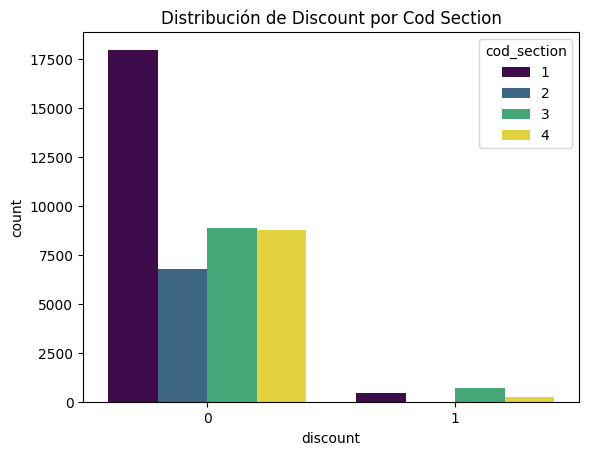

In [29]:
sns.countplot(data=products_df, x='discount', hue='cod_section', palette="viridis")
plt.title('Distribución de Discount por Cod Section')
plt.show()


## Guardado del dataset

In [30]:
# Guardar el DataFrame optimizado
products_df.to_parquet('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_products_transformed.parquet', index=False)
print("El DataFrame optimizado ha sido guardado como 'optimized_products_transformed.parquet'.")

El DataFrame optimizado ha sido guardado como 'optimized_products_transformed.parquet'.


## Resumen

### 1. **Cargar y Explorar el Dataset**:
   - **Cargado del archivo**: El dataset `products` se cargó desde un archivo `products.pkl` utilizando `pickle`. Después, se exploró el contenido y la estructura del dataset.
   - **Descripción inicial**:
     - El dataset contiene **43,692 filas** y **6 columnas**:
       - `discount` (tipo `object`).
       - `embedding` (tipo `object`, con valores nulos).
       - `partnumber` (tipo `int32`).
       - `color_id` (tipo `int32`).
       - `cod_section` (tipo `float64`, con valores nulos).
       - `family` (tipo `int32`).

### 2. **Análisis de Variables Categóricas**:
   - **Exploración de valores únicos**: Se identificaron cuántos valores únicos existen en cada variable categórica.
     - `discount` tiene 2 valores únicos: `0` y `1`.
     - `cod_section` tiene 4 valores únicos.
     - `family` tiene 217 categorías únicas.
   - **Valores nulos**: Se identificaron los valores nulos en el dataset:
     - `embedding`: 6,170 valores nulos.
     - `cod_section`: 90 valores nulos.

### 3. **Optimización del Uso de Memoria**:
   - Se optimizó el tipo de dato de las columnas `discount` y `cod_section` a tipos más pequeños (`int8`) para reducir el uso de memoria sin perder información.
   - Después de la optimización, el dataset ocupa **938.8 KB** en lugar de más de 1.5 MB.

### 4. **Reducción de Embeddings**:
   - **Reducción de dimensionalidad**: Se aplicó PCA (Análisis de Componentes Principales) a los embeddings de productos para reducir su dimensionalidad y hacerlo más manejable.
     - Se utilizaron **300 componentes**, lo que explicó un **88.20% de la varianza** original de los embeddings.
     - Los embeddings reducidos fueron agregados al dataset, y la columna original de `embedding` fue eliminada para evitar redundancia.

### 5. **Visualización de Variables Categóricas**:
   - Se visualizaron las distribuciones de las variables categóricas (`discount`, `cod_section`, `family`) utilizando gráficos de barras (`countplot`).
   - Se visualizó cómo se distribuye la variable `discount` según `cod_section`, mostrando una fuerte desbalance entre las categorías de `discount`.
   - También se exploraron las relaciones entre los embeddings reducidos y las variables categóricas utilizando un mapa de calor para observar cómo los embeddings se agrupan por categorías.

### 6. **Distribución de Variables Categóricas**:
   - **Distribución de `discount`**: La gran mayoría de los registros tienen `discount = 0` (42,314 registros), mientras que solo un pequeño número tiene `discount = 1` (1,378 registros).
   - **Distribución de `cod_section`**: La variable tiene cuatro categorías, con una distribución relativamente equilibrada entre ellas.
   - **Distribución de `family`**: La variable `family` tiene 217 categorías, y algunas de estas categorías tienen solo un registro, lo que genera una distribución dispersa.
   - **Tabla de contingencia**: Se mostró cómo se distribuyen los valores de `discount` entre las categorías de `cod_section`.

### 7. **Relación entre Variables**:
   - **Relación entre `discount` y `cod_section`**: Se generaron tablas de contingencia para mostrar cómo se distribuyen las categorías de `discount` y `cod_section`, revelando que ciertos valores de `discount` están más concentrados en algunas categorías de `cod_section`.

### Sugerencias y próximos pasos:
- **Manejo de valores nulos**: Aunque se identificaron algunos valores nulos en las variables `embedding` y `cod_section`, no se han realizado aún decisiones sobre cómo imputarlos o eliminarlos. Dependiendo de la estrategia de modelado que sigas, puedes decidir eliminar o imputar estos valores.
- **Transformación de variables categóricas**: Antes de combinar este dataset con los de `train/test` y `users`, puedes considerar la transformación de las variables categóricas, como `discount` y `cod_section`, mediante técnicas como one-hot encoding o label encoding, dependiendo de los modelos que vayas a utilizar.
- **Esperar la combinación de datasets**: Como mencionaste, es una buena práctica esperar a tener todos los datasets juntos antes de realizar cambios significativos, para hacer ajustes más informados y eficientes.

In [31]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   discount           43692 non-null  int8  
 1   partnumber         43692 non-null  int32 
 2   color_id           43692 non-null  int32 
 3   cod_section        43692 non-null  int8  
 4   family             43692 non-null  int32 
 5   embedding_reduced  43692 non-null  object
dtypes: int32(3), int8(2), object(1)
memory usage: 938.8+ KB


In [32]:
import pandas as pd

# Verificar que 'embedding_reduced' no tenga valores nulos
embedding_not_null = products_df['embedding_reduced'].notnull().all()

# Convertir las cadenas en listas reales, solo si aún no son listas
def safe_eval(value):
    if isinstance(value, str):
        return eval(value)
    return value

products_df['embedding_reduced'] = products_df['embedding_reduced'].apply(safe_eval)

# Verificar que todas las listas tengan la misma longitud
consistent_length = products_df['embedding_reduced'].apply(len).nunique() == 1

if embedding_not_null and consistent_length:
    print("La columna 'embedding_reduced' no tiene valores nulos y todas las listas tienen la misma longitud.")
else:
    if not embedding_not_null:
        print("La columna 'embedding_reduced' tiene valores nulos.")
    if not consistent_length:
        print("Las listas en la columna 'embedding_reduced' no tienen la misma longitud.")


La columna 'embedding_reduced' no tiene valores nulos y todas las listas tienen la misma longitud.
